<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Interference_models_using_external_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Interference using pretrained models**

In [1]:
import torch
from IPython.display import Image, clear_output
import os
import shutil
import glob

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#GDriveをマウント
from google.colab import drive
drive.mount('/content/drive')

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)
Mounted at /content/drive


In [46]:
dataset_folder_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/for_validation"

mobileNet_model_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/MobileNetV3_aug2.pth"
YOLOv5_model_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
# specify the image paths

# 番号順に並べる
# https://dlrecord.hatenablog.com/entry/2020/07/30/230234


import re
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

grav_list = sorted([i for i in glob.glob(f"{dataset_folder_path}/treated_640px/*")], key=natural_keys)
cont_list = sorted([i for i in glob.glob(f"{dataset_folder_path}/control_640px/*")], key=natural_keys)
image_list = grav_list + cont_list
label_list = [1]*len(grav_list) + [0]*len(cont_list)

image_list


In [48]:
# show sample images
import matplotlib.pyplot as plt
import cv2
import os

root = f"{dataset_folder_path}/treated_640px" #画像があるフォルダ。適宜変えてください
lsdir = os.listdir(root)

imgs = []
for l in lsdir:
    target = os.path.join(root,l)
    img = cv2.imread(target)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #pyplotで表示するために色変換
    imgs.append(img)

shownumber = 6 #画像を並べる数
showaxis = 1

while(showaxis*showaxis < shownumber):
    showaxis += 1

cnt = 0
while(1):
    limit = 6
    if cnt >= limit:
       break
    fig,axs = plt.subplots(showaxis,showaxis, figsize=(16.0, 12.0))
    ar = axs.ravel()
    for i in range(showaxis*showaxis):
        ar[i].axis('off')
        if i < shownumber:
            ar[i].imshow(imgs[cnt])
            cnt += 1
    plt.show()

###**MobileNetV3 interference**

In [49]:
##########################
# Load model 
##########################
!pip install --quiet timm
import timm
import torch.nn as nn

model_ft = timm.create_model('mobilenetv3_large_100', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

#ネットワークの読み込み
model_ft.load_state_dict(torch.load(mobileNet_model_path))

<All keys matched successfully>

In [50]:
from torchvision import datasets, models, transforms
from PIL import *
import pandas as pd


img_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = img_transforms(image).float()
    image = image.unsqueeze(0) 
    return image.to(device)

def my_round(val, digit=0):
    p = 10 ** digit
    return (val * p * 2 + 1) // 2 / p

def interference(image_list):
    image_tensor = image_loader(path)

    model_ft.to(device)
    model_ft.eval()
    output = model_ft(image_tensor)
    _, pred = torch.max(output, 1) 
    pred = pred[0].to('cpu').detach().numpy().copy().tolist() 

    prob = nn.Softmax(dim=1)(output) #calculate probalility
    prob = prob[0][1].cpu().detach().numpy().copy().tolist() #probalility of being positive
    prob = my_round(prob, 3)

    return pred, prob, image_tensor

In [51]:
# multiple image eval
path_list, pred_list, prob_list = [], [], []
for idx, path in enumerate(image_list, 1):
    pred, prob, _ = interference(path)
    path_list.append(os.path.basename(path)) 
    pred_list.append(pred)
    prob_list.append(prob)
print(label_list)
print(pred_list)
print(prob_list)

df = pd.DataFrame(index=[], columns=[])
df["path"] = path_list
df["label"] = label_list
df["pred_MobileNet"] = pred_list
df["prob_MobileNet"] = prob_list
df.to_csv('/content/interference.csv', header=True, index=False, encoding = "utf-8")

pd.set_option('display.max_rows', 400)
df



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,path,label,pred_MobileNet,prob_MobileNet
0,4.JPG,1,1,0.920
1,6.JPG,1,1,0.923
2,16.JPG,1,1,0.647
3,30.JPG,1,1,0.827
4,42.JPG,1,1,0.760
5,43.JPG,1,1,0.936
6,45.JPG,1,1,0.707
7,49.JPG,1,1,0.922
8,63.JPG,1,1,0.991
9,73.JPG,1,1,0.859


In [52]:
pd.set_option('display.max_rows', None)
df

,path,label,pred_MobileNet,prob_MobileNet
0,4.JPG,1,1,0.920
1,6.JPG,1,1,0.923
2,16.JPG,1,1,0.647
3,30.JPG,1,1,0.827
4,42.JPG,1,1,0.760
5,43.JPG,1,1,0.936
6,45.JPG,1,1,0.707
7,49.JPG,1,1,0.922
8,63.JPG,1,1,0.991
9,73.JPG,1,1,0.859


In [53]:
# single image eval
num = 5
path = image_list[num]
label = label_list[num]
print(f"path: {path}")

pred, prob, tensor = interference(path) 
print(f"label: {label}, pred: {pred}, prob: {prob}")
print(tensor)

path: /content/drive/MyDrive/Deep_learning/Olympia_dataset/for_validation/treated_640px/43.JPG
label: 1, pred: 1, prob: 0.936
tensor([[[[-1.53566, -1.48429, -1.45004,  ..., -1.87816, -1.87816, -1.84391],
          [-1.56991, -1.43291, -1.39866,  ..., -1.87816, -1.89528, -1.87816],
          [-1.56991, -1.41579, -1.34729,  ..., -1.87816, -1.87816, -1.91241],
          ...,
          [-1.21029, -1.17604, -1.10754,  ..., -0.30268, -0.37118, -0.40543],
          [-1.24454, -1.19317, -1.12467,  ..., -0.31980, -0.28556, -0.37118],
          [-1.26167, -1.19317, -1.10754,  ..., -0.37118, -0.35405, -0.40543]],

         [[-1.52801, -1.45798, -1.45798,  ..., -1.82563, -1.84314, -1.84314],
          [-1.52801, -1.40546, -1.37045,  ..., -1.84314, -1.84314, -1.86064],
          [-1.54552, -1.40546, -1.35294,  ..., -1.84314, -1.86064, -1.87815],
          ...,
          [-1.35294, -1.35294, -1.31793,  ..., -0.89776, -0.89776, -0.93277],
          [-1.37045, -1.35294, -1.31793,  ..., -0.91527, -0.88

###**YOLOv5n interference**

In [41]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/166.8 GB disk)


In [ ]:
# # Inference (folder内全部)
# !python detect.py --weights $YOLOv5_model_path --img 640 --conf 0.25 --source {dataset_folder_path}/treated_640px


In [54]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
image_path = image_list
img = image_path[102]

class_names = {0:"cont", 1:"grav"}
pred = interference(img, YOLOv5_model_path)

# output result
x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

# probability
prob = pred[0][0][4].item()

# class
class_name = class_names[pred[0][0][5].item()]

print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

img_cv2 = cv2.imread(img) 

# 横幅が640pxになるようにリサイズ
height, width, _ = img_cv2.shape
resize_width = 640
resize_height = int((height / width) * resize_width)
resize_size = (resize_width, resize_height)
img_cv2 = cv2.resize(img_cv2, resize_size)

# calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
img_height, img_width, _ = img_cv2.shape[:3]
print(f"img_height: {img_height}, img_width: {img_width}")
padding_x = (img_height - min(img_width, img_height))/2
padding_y = (img_width - min(img_width, img_height))/2
x1 = x1 - padding_x
y1 = y1 - padding_y
x2 = x2 - padding_x
y2 = y2 - padding_y
print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")


# draw bounding box
cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

# show image
cv2_imshow(img_cv2)

In [58]:
pred_list, prob_list = [], []

for img in image_list:
    pred = interference(img, YOLOv5_model_path)
    # output result
    # x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # class
    prob = pred[0][0][4].item()
    prob_list.append(prob)
    # class
    class_num = int(pred[0][0][5].item())
    pred_list.append(class_num)

df["pred_YOLOv5"] = pred_list
df["prob_YOLOv5"] = prob_list

df.to_csv('/content/interference.csv', header=True, index=False, encoding = "utf-8")

pd.set_option('display.max_rows', 400)
df

YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-3.64532e-01,  1.54899e+02,  6.34621e+02,  4.33825e+02,  8.50004e-01,  1.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.99515, 189.23412, 635.07349, 473.68884,   0.91275,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -0.62939, 224.15829, 621.94604, 480.06168,   0.81822,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-5.14038e-01,  1.84672e+02,  6.39227e+02,  4.88738e+02,  6.33306e-01,  0.00000e+00],
        [ 4.04434e+00,  1.82411e+02,  6.43472e+02,  4.86469e+02,  4.81325e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.12088, 171.91127, 639.78967, 471.65833,   0.82011,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  5.01074, 168.57367, 637.54688, 463.71045,   0.90170,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.59668, 168.62160, 636.25989, 456.84766,   0.77803,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.22260, 175.45988, 637.43280, 480.55273,   0.90467,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-2.47498e-01,  1.98711e+02,  6.13107e+02,  4.75718e+02,  9.60795e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[1.32043e+00, 1.55146e+02, 6.34085e+02, 4.41905e+02, 6.08045e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  3.06305, 200.59273, 637.23987, 480.51019,   0.92452,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -3.45758, 199.61716, 638.69336, 467.53659,   0.76523,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.66977, 175.68175, 636.03516, 449.99170,   0.88760,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.90732, 168.47510, 639.24402, 495.07098,   0.89388,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.47989, 195.46942, 640.70837, 466.06665,   0.87368,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.32660, 196.54091, 636.60181, 483.36371,   0.93516,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -0.96173, 151.25027, 637.90479, 446.42117,   0.64995,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.23315, 155.10075, 638.81329, 466.55658,   0.64266,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.77341, 207.60945, 629.97974, 477.17786,   0.91070,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-9.28802e-01,  1.81950e+02,  6.35929e+02,  4.84971e+02,  5.96995e-01,  0.00000e+00],
        [ 2.16022e+00,  1.84453e+02,  6.39245e+02,  4.82406e+02,  5.82620e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.23264, 152.37756, 640.58899, 453.29926,   0.91099,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-3.36243e-01,  1.96822e+02,  6.41055e+02,  5.00562e+02,  5.32690e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.30701e+00,  1.91463e+02,  6.29475e+02,  4.84556e+02,  8.70569e-01,  1.00000e+00],
        [-1.88434e+00,  1.92762e+02,  6.29864e+02,  4.80487e+02,  5.00254e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.36545, 186.13617, 638.90588, 461.53979,   0.84797,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -2.66888, 167.26917, 632.93671, 464.65759,   0.91808,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.21863e-02,  1.57831e+02,  6.39054e+02,  4.30376e+02,  8.73865e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -4.14050, 163.68608, 614.66321, 426.97968,   0.88639,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-5.47241e-01,  1.46791e+02,  6.38417e+02,  4.45910e+02,  9.11015e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.49585, 174.73694, 639.47791, 483.60840,   0.85798,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[7.12949e+00, 1.81350e+02, 6.43155e+02, 4.72497e+02, 6.63503e-01, 1.00000e+00],
        [1.41210e+01, 1.83613e+02, 6.41918e+02, 4.74940e+02, 2.97111e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-2.92389e-01,  1.73681e+02,  6.12414e+02,  4.29671e+02,  9.31339e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.11285e+00, 1.77250e+02, 6.40054e+02, 4.72265e+02, 6.39120e-01, 0.00000e+00],
        [1.67960e+00, 1.80220e+02, 6.43160e+02, 4.64388e+02, 3.66419e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.87634e+00,  1.57869e+02,  6.32997e+02,  4.30226e+02,  6.00298e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-6.13007e-01,  1.83999e+02,  6.40003e+02,  4.86036e+02,  6.85578e-01,  0.00000e+00],
        [ 1.81641e+00,  1.77674e+02,  6.41667e+02,  4.84688e+02,  4.69393e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.73590e-01, 1.84383e+02, 6.38477e+02, 4.93047e+02, 7.35378e-01, 1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.09351e-01, 1.75744e+02, 6.36335e+02, 4.67615e+02, 7.35006e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.05331e+00, 1.80511e+02, 6.41480e+02, 4.84830e+02, 4.75869e-01, 0.00000e+00],
        [2.40720e+00, 1.83521e+02, 6.40642e+02, 4.87989e+02, 4.70838e-01, 1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.36914, 163.26724, 636.69232, 464.74393,   0.81576,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.04214, 167.27547, 637.84924, 484.28760,   0.89199,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.90344, 165.65575, 637.37274, 458.60083,   0.82832,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.67593, 164.30911, 640.71619, 498.44437,   0.89659,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.22321e-01,  1.69150e+02,  6.38627e+02,  4.84990e+02,  8.41348e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.87915, 132.63721, 638.04877, 436.82666,   0.76750,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -2.86844, 180.05562, 630.76050, 472.55231,   0.93196,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.28601e-01,  1.46308e+02,  6.33952e+02,  4.36483e+02,  8.60640e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.74548, 152.58067, 636.75238, 437.03656,   0.75058,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-4.73145e-01,  1.82173e+02,  6.39961e+02,  5.22805e+02,  7.99812e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.97333, 193.14917, 637.35980, 467.64124,   0.91821,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  9.22131, 217.87836, 642.08478, 485.67755,   0.87582,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.70157, 142.73120, 635.40503, 436.80066,   0.82029,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.22266, 168.75876, 636.93286, 459.13382,   0.81704,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 10.39142, 196.99020, 641.73645, 488.45840,   0.91367,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  6.33310, 171.65781, 638.57446, 465.40781,   0.85001,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -3.99017, 130.29094, 640.21783, 456.01410,   0.85794,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.91833e-01,  1.67679e+02,  6.39703e+02,  4.81648e+02,  6.49727e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.01532, 177.56613, 639.85950, 498.16080,   0.91149,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.17673, 182.27744, 638.43311, 483.85526,   0.90716,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.71814e-01, 2.08189e+02, 6.33029e+02, 5.06015e+02, 8.59439e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  3.21585, 178.01949, 639.73364, 470.73621,   0.88570,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  6.86621, 201.59999, 622.70947, 467.40765,   0.94432,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.28854, 138.32318, 639.56494, 474.31854,   0.90228,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  7.49738, 173.84886, 630.38342, 453.76355,   0.89184,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.08752, 197.58333, 639.36206, 483.37225,   0.88930,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  0.84421, 163.36853, 638.39111, 490.92365,   0.87153,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  5.42636, 183.25609, 634.64880, 469.53363,   0.92021,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.86661, 199.79253, 642.48877, 488.11865,   0.76435,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.09207, 183.17273, 641.44519, 477.24121,   0.91364,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.15414, 192.01778, 632.46484, 479.62622,   0.93474,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.23557, 191.85529, 642.71545, 489.67804,   0.84060,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.38727, 151.41898, 637.76923, 433.92355,   0.76711,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.60492e-01, 1.80585e+02, 6.39379e+02, 4.72036e+02, 8.65015e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.59485, 153.34274, 636.65674, 449.98050,   0.87397,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.06870, 107.30736, 635.56458, 371.96545,   0.90174,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.48984, 179.18408, 641.07617, 483.69733,   0.88883,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.33118, 165.24069, 641.21936, 466.15012,   0.80867,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.05441, 164.41692, 632.40601, 450.69446,   0.93081,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  8.35751, 165.93437, 641.98682, 468.41119,   0.91480,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -0.74954, 164.15056, 638.07947, 459.02570,   0.79848,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -2.37234, 176.93207, 630.77869, 466.90747,   0.87681,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[8.79391e+00, 2.07676e+02, 6.39953e+02, 4.56321e+02, 8.19103e-01, 1.00000e+00],
        [4.69241e+00, 2.03496e+02, 6.40767e+02, 4.60866e+02, 4.36837e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.59210, 212.06267, 632.15698, 477.63928,   0.77744,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.03851e-01,  1.65674e+02,  6.38232e+02,  4.80080e+02,  5.41348e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.50836e+00,  1.47900e+02,  6.34005e+02,  4.51017e+02,  4.94850e-01,  0.00000e+00],
        [ 6.98242e-01,  1.53234e+02,  6.31378e+02,  4.52861e+02,  4.88269e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-2.08160e-01,  1.63009e+02,  6.36404e+02,  4.89749e+02,  8.50947e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-3.98602e+00,  1.38471e+02,  6.39443e+02,  4.54372e+02,  6.33786e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.19888, 192.87164, 638.36023, 477.51959,   0.90608,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 3.37308e+00,  1.60340e+02,  6.40698e+02,  4.62136e+02,  6.38156e-01,  0.00000e+00],
        [-1.24832e+00,  1.59883e+02,  6.39542e+02,  4.60762e+02,  5.03311e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.32068, 144.47902, 635.64471, 439.46100,   0.69168,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.96103, 189.02449, 639.08264, 492.98065,   0.91844,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.75946, 154.72449, 636.69495, 464.05261,   0.90537,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.36282, 135.85770, 638.71936, 444.80093,   0.80211,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  3.95135, 131.68729, 639.70850, 449.17746,   0.73952,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.68332, 183.14589, 642.86340, 497.99329,   0.92749,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.72375, 158.42072, 636.40198, 459.17572,   0.74778,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[9.15527e-02, 1.47309e+02, 6.37973e+02, 4.43573e+02, 9.10895e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  8.29684, 161.17154, 638.84302, 466.52841,   0.92571,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.52881e-01, 1.53976e+02, 6.32554e+02, 4.62490e+02, 8.87072e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.73471, 186.29535, 635.19849, 480.54016,   0.74233,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.19284, 189.14609, 639.43506, 467.48679,   0.91367,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.20898, 150.35799, 612.78894, 470.74005,   0.95907,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 12.55869, 161.67902, 624.49097, 461.42395,   0.89321,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 20.95953, 158.12766, 639.44934, 452.42825,   0.83050,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.70175, 178.72852, 626.69983, 448.04156,   0.81665,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.86288, 170.50136, 636.60120, 493.76233,   0.90783,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-3.17902e-01,  1.68944e+02,  6.36848e+02,  4.51071e+02,  8.92418e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.45010, 185.80035, 640.33069, 469.25177,   0.88965,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.88599, 191.73358, 640.30164, 468.81891,   0.87383,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.66922, 180.77499, 639.36804, 489.58279,   0.88958,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -2.23035, 137.11754, 636.11841, 449.45282,   0.85941,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.73462e-01,  1.81527e+02,  6.38817e+02,  4.84769e+02,  8.98121e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -0.94043, 140.82458, 638.36340, 443.52563,   0.86597,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  9.49100, 192.65804, 629.91125, 459.73126,   0.88235,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 25.47580, 179.86960, 644.94678, 467.51468,   0.92433,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[1.10324e+00, 1.78229e+02, 6.42105e+02, 4.75062e+02, 6.35522e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  8.05603, 137.93996, 638.26044, 417.41803,   0.92406,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  4.08194, 182.75610, 640.09119, 493.26459,   0.91441,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.43250, 212.77280, 630.25757, 496.08511,   0.75823,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-5.11688e-01,  1.91015e+02,  6.40644e+02,  4.83375e+02,  6.45190e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.75583, 125.21432, 634.25061, 427.89737,   0.91925,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  8.13025, 136.54361, 642.20337, 457.52518,   0.90790,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.16724, 231.13962, 638.42010, 501.87375,   0.80263,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.45300, 206.21722, 634.53235, 500.56946,   0.70816,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.77692e-01, 1.79717e+02, 6.38864e+02, 4.73286e+02, 7.23345e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -0.85959, 188.27469, 640.35364, 481.67123,   0.77359,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.35468, 159.68468, 638.37762, 461.20044,   0.91231,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[5.33417e-01, 1.32745e+02, 6.36122e+02, 4.37665e+02, 6.76199e-01, 0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  8.41135, 219.71735, 637.29956, 502.00146,   0.94453,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-5.75024e+00,  1.55694e+02,  6.38951e+02,  4.53148e+02,  5.83307e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  0.96127, 157.29486, 638.28369, 449.60730,   0.81417,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.95279, 150.95808, 637.09937, 476.85138,   0.84258,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.04001, 167.03831, 642.21411, 492.45251,   0.86921,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  6.35599, 159.81152, 641.38318, 464.38556,   0.92495,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  2.50488, 192.49199, 638.60638, 476.20996,   0.92500,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[3.08228e-01, 1.84042e+02, 6.28787e+02, 4.74276e+02, 7.02885e-01, 0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.36429, 163.99763, 627.68958, 450.22430,   0.81580,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.07800, 144.81248, 639.03632, 463.30530,   0.87781,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.38217, 175.82942, 640.64612, 483.08899,   0.82766,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 20.93451, 184.01930, 641.07709, 460.92371,   0.89217,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-6.58630e-01,  1.55471e+02,  6.39208e+02,  4.45622e+02,  6.36165e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-1.98700e-01,  1.92878e+02,  6.36842e+02,  4.64556e+02,  9.12871e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.10971, 201.70773, 633.40344, 472.98917,   0.91644,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-3.99353e-01,  1.49096e+02,  6.41500e+02,  4.53296e+02,  7.53302e-01,  0.00000e+00],
        [-2.01761e+00,  1.46074e+02,  6.38742e+02,  4.48907e+02,  6.12402e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  0.80463, 141.93538, 639.64124, 453.55115,   0.86127,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[5.84381e-01, 1.42239e+02, 6.36509e+02, 4.43772e+02, 8.92019e-01, 1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.45172, 177.74066, 637.77997, 473.19061,   0.81291,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.58212, 201.30103, 642.82568, 479.66809,   0.73291,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 18.72333, 218.01111, 641.70465, 477.91541,   0.91843,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.01028, 183.46875, 634.88086, 502.68445,   0.88889,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.37955, 172.46719, 642.26184, 473.36600,   0.71541,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.66336, 179.23769, 636.51392, 482.32581,   0.90436,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.46347, 181.39194, 636.84973, 477.89706,   0.92033,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.17575, 177.77159, 633.58972, 481.39325,   0.92915,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.82483e-02, 1.55975e+02, 6.33504e+02, 4.27159e+02, 7.94260e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.47977e+00, 1.79340e+02, 6.39913e+02, 4.67079e+02, 6.78509e-01, 1.00000e+00],
        [3.17319e+00, 1.80035e+02, 6.41436e+02, 4.74578e+02, 5.19089e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-5.29419e-01,  1.60147e+02,  6.32749e+02,  4.39112e+02,  9.45416e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.48373, 186.54802, 639.47327, 501.87567,   0.79902,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-5.63202e-01,  1.49147e+02,  6.40434e+02,  4.48074e+02,  9.03914e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  5.80029, 173.55312, 640.24280, 463.00964,   0.75292,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  4.96500, 148.16553, 639.48364, 447.39630,   0.92757,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.72198, 155.87366, 641.00537, 452.30200,   0.89946,   1.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.60678, 186.37262, 640.61755, 475.53003,   0.89116,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.24377, 150.10008, 640.19623, 450.71869,   0.87981,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.32419, 178.65976, 640.02808, 493.39023,   0.91223,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 15.60049, 216.95010, 642.19897, 473.84097,   0.87177,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.39355, 180.58096, 640.99011, 479.53677,   0.67177,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.85541, 154.87349, 639.98700, 470.49341,   0.90510,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 26.93787, 211.68587, 642.60309, 499.67603,   0.91308,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  4.68411, 178.60201, 639.97876, 469.27228,   0.88724,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.36783e+00, 1.52273e+02, 6.34891e+02, 4.21267e+02, 5.79853e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.72198e-01, 2.18845e+02, 6.30167e+02, 4.81035e+02, 7.80268e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[3.73749e-01, 1.65264e+02, 6.32572e+02, 4.46190e+02, 9.11527e-01, 1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 18.64575, 190.98557, 640.77264, 456.96475,   0.91585,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-1.20361e-01,  1.52566e+02,  6.35635e+02,  4.39737e+02,  8.78379e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 11.03439, 212.64012, 624.72534, 481.97021,   0.88543,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.23236, 183.78688, 638.20111, 482.97797,   0.90566,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[3.95447e-01, 1.90576e+02, 6.31402e+02, 4.56880e+02, 9.00750e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  6.56158, 163.76126, 641.01813, 436.26126,   0.93152,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.52991, 167.72336, 640.45026, 450.59457,   0.92786,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -3.05304, 194.56490, 635.79791, 489.06293,   0.81617,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.07712, 214.19919, 627.63733, 476.98056,   0.91704,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.72684e+00,  1.49944e+02,  6.36255e+02,  4.31661e+02,  6.21577e-01,  0.00000e+00],
        [ 1.87170e+00,  1.51121e+02,  6.39588e+02,  4.29347e+02,  4.14436e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[6.84204e-02, 1.60215e+02, 6.35209e+02, 4.51116e+02, 8.88981e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.17487, 154.61461, 640.90735, 468.45898,   0.82553,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  8.57199, 178.91270, 640.05762, 465.89001,   0.88472,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-3.39572e+00,  1.69114e+02,  6.33334e+02,  4.75466e+02,  5.00785e-01,  1.00000e+00],
        [-1.78510e+00,  1.68371e+02,  6.34640e+02,  4.85142e+02,  4.45269e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-6.62842e-02,  2.09580e+02,  6.25967e+02,  4.61855e+02,  9.47353e-01,  0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ -1.17371, 153.34483, 623.01636, 438.63190,   0.94030,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.31665, 201.23865, 638.61725, 498.80164,   0.72034,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.25107, 190.83536, 639.88513, 471.25607,   0.90591,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.19397, 161.34048, 636.12231, 462.25900,   0.89470,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 27.68048, 222.33710, 640.60480, 465.63971,   0.93617,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-1.07901e+00,  1.43125e+02,  6.38881e+02,  4.46320e+02,  4.81630e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[7.25693e+00, 1.62403e+02, 6.41036e+02, 4.66628e+02, 6.38693e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 11.86270, 189.13530, 629.24292, 454.46497,   0.82435,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.92661, 160.48003, 638.00708, 453.66705,   0.90705,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.63763, 150.08073, 624.81317, 433.78644,   0.91009,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.20789, 153.74101, 638.35187, 469.82715,   0.86696,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.39514, 148.25571, 638.37646, 467.42404,   0.89043,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.16577e-02,  1.74271e+02,  6.40142e+02,  4.90027e+02,  8.11625e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-3.51593e-01,  1.84262e+02,  6.40929e+02,  4.77183e+02,  9.15610e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.99750, 174.09012, 637.15302, 455.52213,   0.89878,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -2.88425, 210.44234, 634.81946, 481.03485,   0.92403,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 1.20898e+00,  1.78928e+02,  6.41042e+02,  4.83378e+02,  5.96428e-01,  0.00000e+00],
        [-1.50476e+00,  1.75700e+02,  6.37640e+02,  4.80167e+02,  4.87120e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.36469, 167.66808, 640.27576, 485.23901,   0.73666,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.88068e-01, 1.89756e+02, 6.38763e+02, 4.57872e+02, 8.69632e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[1.87650e+00, 1.58533e+02, 6.41128e+02, 4.68539e+02, 6.19035e-01, 0.00000e+00],
        [2.64005e+00, 1.61073e+02, 6.40035e+02, 4.69317e+02, 4.48100e-01, 1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.34183, 183.88667, 641.11096, 497.37689,   0.87065,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[5.06409e-01, 1.50448e+02, 6.38964e+02, 4.38558e+02, 8.87699e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.58075, 169.40887, 641.34882, 462.10474,   0.86469,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.55734, 170.99748, 639.06848, 480.70294,   0.70420,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.13574, 196.45386, 623.85468, 454.07007,   0.91917,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-2.29370e-01,  1.64662e+02,  6.37019e+02,  4.16967e+02,  7.95821e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.08160e-01, 1.24826e+02, 6.38265e+02, 4.14497e+02, 8.61282e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-6.37512e-02,  1.86599e+02,  6.43463e+02,  4.82929e+02,  9.24432e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.63177e+00, 1.77388e+02, 6.40723e+02, 4.89756e+02, 5.95690e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -0.85266, 152.63995, 619.93640, 433.54456,   0.90828,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -0.81900, 173.70471, 642.12769, 500.75592,   0.74556,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.78638, 189.32745, 639.45996, 499.65961,   0.78910,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[7.39746e-02, 1.45329e+02, 6.34718e+02, 4.28950e+02, 6.72859e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.68365, 165.63344, 638.81561, 490.64673,   0.85329,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.04913, 222.61485, 634.58698, 488.55872,   0.79982,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.24014e+00,  1.74789e+02,  6.39795e+02,  4.74911e+02,  5.70303e-01,  0.00000e+00],
        [-4.18640e-01,  1.73592e+02,  6.40500e+02,  4.77754e+02,  5.62040e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.03137, 185.78816, 638.12048, 491.33142,   0.90047,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  6.25281, 186.70677, 633.23352, 462.79895,   0.86516,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.35388, 170.59145, 638.81476, 461.34894,   0.76517,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -2.51199, 142.89246, 626.48450, 432.28918,   0.87749,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.27057, 174.77953, 639.66095, 482.92059,   0.84119,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[4.47327e-01, 1.43379e+02, 6.40022e+02, 4.54371e+02, 8.25246e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 14.45230, 183.52826, 640.28748, 468.04486,   0.86605,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[5.62805e-01, 2.31187e+02, 6.32906e+02, 5.15504e+02, 8.47755e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  9.94992, 195.26843, 643.51941, 509.61969,   0.85281,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  5.15182, 198.99042, 630.45752, 469.75195,   0.93617,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.14993, 180.31841, 639.43176, 450.22400,   0.84518,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  0.77325, 207.42570, 635.44177, 502.97437,   0.78534,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -0.84732, 188.72598, 639.55750, 476.20938,   0.91364,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.57770, 188.71802, 639.49963, 463.98596,   0.82222,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -4.62103, 192.25136, 624.21930, 448.16742,   0.85706,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[9.42657e-01, 1.79619e+02, 6.37192e+02, 4.86798e+02, 5.58106e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 18.38776, 165.70795, 640.49854, 450.69891,   0.85412,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  0.88708, 193.21887, 640.77380, 486.10516,   0.86693,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.31497, 183.78612, 638.98596, 481.14166,   0.91135,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  8.11163, 216.90041, 640.64148, 493.01215,   0.81028,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-6.04645e-01,  1.59681e+02,  6.36249e+02,  4.64083e+02,  8.86230e-01,  0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -2.43909, 133.77292, 637.47858, 436.55759,   0.79169,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  4.81131, 215.28180, 637.34021, 488.40765,   0.79372,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.05225, 181.22423, 638.31238, 466.43420,   0.85681,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.21170, 200.11690, 640.13647, 471.02008,   0.91232,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[3.64319e-01, 2.20413e+02, 6.39506e+02, 4.86478e+02, 8.10565e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.28400e+00,  1.70435e+02,  6.28787e+02,  4.71780e+02,  4.38535e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[3.24005e-01, 1.78587e+02, 6.38226e+02, 4.78910e+02, 7.57868e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.15942, 187.04053, 637.49237, 482.61365,   0.84499,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.58203e-01,  1.95160e+02,  6.34708e+02,  4.90250e+02,  5.24837e-01,  0.00000e+00],
        [-4.67441e+00,  1.95322e+02,  6.35115e+02,  4.85227e+02,  4.76546e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-7.80334e-02,  1.99200e+02,  6.36042e+02,  4.82158e+02,  9.13947e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.92035, 215.79250, 637.37598, 502.49585,   0.86584,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.16772, 158.40962, 638.12042, 495.67639,   0.79481,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.15509, 162.64101, 635.33514, 441.25269,   0.91678,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.09207, 183.17273, 641.44519, 477.24121,   0.91364,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 13.52191, 185.17336, 645.29803, 473.08997,   0.89455,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[5.78796e-01, 1.41137e+02, 6.35170e+02, 4.50854e+02, 8.85992e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.58435e+00, 1.23607e+02, 6.39089e+02, 4.45485e+02, 5.18380e-01, 1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.22937, 202.82106, 638.80402, 479.91241,   0.89418,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.89230, 151.75024, 640.70251, 462.04694,   0.90938,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.84161, 176.05756, 634.56757, 458.67267,   0.83436,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.59210, 212.06267, 632.15698, 477.63928,   0.77744,   1.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.89606e-01,  2.31993e+02,  6.21007e+02,  5.13354e+02,  9.59513e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  4.34055, 182.68001, 640.47253, 468.10309,   0.89402,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 10.09586, 206.99765, 634.67993, 480.68008,   0.91760,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 21.91406, 245.57912, 632.85345, 507.21783,   0.95041,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-2.99896e-01,  1.77875e+02,  6.40458e+02,  4.70425e+02,  8.73702e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[ 17.69781, 193.60159, 640.10712, 476.10385,   0.85141,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-1.06720e-01,  1.63792e+02,  6.38380e+02,  4.50929e+02,  8.99380e-01,  0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.38916, 158.24815, 640.10156, 446.81793,   0.88919,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[2.87109e-01, 1.76443e+02, 6.40271e+02, 4.71274e+02, 8.51242e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[9.26422e-01, 1.84230e+02, 6.38479e+02, 4.66055e+02, 6.17758e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  3.82428, 143.29353, 641.46222, 438.26099,   0.84695,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  9.93640, 182.34074, 629.25476, 471.63116,   0.79641,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 39.05405, 155.60414, 631.93445, 436.81543,   0.94251,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-4.23492e-01,  1.35754e+02,  6.36778e+02,  4.33567e+02,  8.23779e-01,  0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.60214, 171.31726, 636.52356, 458.98114,   0.77400,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.51279, 183.52855, 641.42944, 481.31903,   0.89633,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.81158, 172.00331, 636.78455, 462.98193,   0.79637,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.64252e-01,  1.40582e+02,  6.35250e+02,  4.40260e+02,  9.08072e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-4.92279e-01,  1.71776e+02,  6.41917e+02,  4.84539e+02,  8.47030e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.35614, 118.86644, 639.27020, 439.58575,   0.90422,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[4.45343e-01, 1.78295e+02, 6.39805e+02, 4.35404e+02, 9.22071e-01, 0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  7.73734, 185.35962, 641.15894, 457.34772,   0.85416,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.23837, 175.89752, 641.38049, 490.40869,   0.88596,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  2.64490, 160.55481, 639.06689, 457.44427,   0.88250,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ -1.14963, 164.25322, 639.74255, 488.21155,   0.84595,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  8.60095, 212.18645, 602.53412, 460.68817,   0.93344,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  0.94882, 148.66891, 637.43591, 434.60526,   0.86550,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[ 14.05148, 202.55440, 641.67651, 463.67999,   0.93999,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  1.58527, 164.38824, 639.36334, 446.90161,   0.90665,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.35736, 146.27452, 635.98425, 438.76978,   0.82940,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.71649, 167.51863, 642.33105, 457.32697,   0.93526,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[-3.51685e-01,  1.40287e+02,  6.37027e+02,  4.48443e+02,  6.25862e-01,  1.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.87854, 148.01848, 640.97717, 441.94843,   0.87037,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.36871, 211.86920, 639.37665, 474.94965,   0.93534,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.71478, 164.28349, 636.41980, 470.31891,   0.89497,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 14.04370, 203.43405, 637.22363, 482.18594,   0.85381,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.73053, 164.11217, 636.36560, 468.25049,   0.86727,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.10123, 158.78049, 615.19019, 438.58780,   0.95828,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.53632, 192.21550, 640.22766, 497.03845,   0.88016,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.94824, 210.81252, 641.99188, 496.62970,   0.83754,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-1.98669e-02,  1.48979e+02,  6.34918e+02,  4.50907e+02,  9.01212e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.24258, 201.48531, 637.18372, 472.27081,   0.82978,   1.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.85242, 190.83755, 626.20386, 450.52219,   0.80253,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  4.83423, 155.78328, 643.05743, 458.49768,   0.92622,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.27219, 211.35202, 639.39441, 485.53604,   0.75546,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[3.61633e-02, 1.55546e+02, 6.41666e+02, 4.65698e+02, 8.54122e-01, 0.00000e+00]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 30.74832, 171.65968, 642.90930, 460.57324,   0.90951,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ -1.74454, 190.21741, 639.90710, 472.71667,   0.90140,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.94983, 191.74689, 624.33484, 472.74725,   0.76036,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.41699e-01,  2.08757e+02,  6.35608e+02,  4.94839e+02,  7.57883e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[  3.94043, 185.07004, 639.88190, 445.49350,   0.86938,   0.00000]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.39600, 168.81117, 638.48285, 449.83508,   0.89169,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-1.53210e+00,  1.99561e+02,  6.20880e+02,  4.70861e+02,  8.57179e-01,  0.00000e+00],
        [ 2.52625e+00,  2.05511e+02,  6.20879e+02,  4.65870e+02,  4.80367e-01,  1.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  4.71915, 176.62999, 640.16138, 464.58856,   0.81332,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  6.38660, 209.19350, 638.22241, 467.18280,   0.88527,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.36520, 178.51018, 641.14441, 478.41541,   0.86956,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 8.37769e-01,  1.71038e+02,  6.40089e+02,  4.88293e+02,  6.93392e-01,  0.00000e+00],
        [-1.41101e+00,  1.72215e+02,  6.37293e+02,  4.88709e+02,  4.66142e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.33508, 170.92297, 638.58459, 438.80505,   0.77763,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.71027, 138.43765, 640.26947, 438.73196,   0.80460,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-3.51074e-01,  1.62736e+02,  6.39282e+02,  4.87186e+02,  7.80486e-01,  1.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 12.31543, 206.86554, 624.09766, 459.70337,   0.92323,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.99387, 170.09781, 632.41101, 452.95352,   0.89294,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  1.05038, 201.17920, 638.23315, 505.83508,   0.77521,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-5.39246e-02,  1.64462e+02,  6.35577e+02,  4.67257e+02,  8.36002e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-4.88373e-01,  1.36023e+02,  6.34990e+02,  4.26173e+02,  7.83793e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.69531, 189.41695, 638.91046, 456.23749,   0.82859,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[-2.29919e-01,  1.47503e+02,  6.39169e+02,  4.59289e+02,  8.75370e-01,  0.00000e+00]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  3.91632, 154.92838, 634.20331, 455.51358,   0.92152,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  2.60828, 171.96550, 638.35992, 471.38806,   0.80226,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU



pred: [tensor([[  1.31470, 126.49475, 635.59760, 443.14667,   0.82363,   0.00000]])]


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[  0.80612, 159.97119, 641.47327, 468.48547,   0.82432,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 


pred: [tensor([[ 12.84915, 180.01761, 637.30469, 472.81235,   0.92927,   0.00000]])]


Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[-2.50793e-01,  1.57278e+02,  6.35746e+02,  4.41274e+02,  8.30568e-01,  0.00000e+00]])]


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


pred: [tensor([[1.15372e+00, 1.49378e+02, 6.22003e+02, 4.22754e+02, 6.18575e-01, 0.00000e+00]])]


,path,label,pred_MobileNet,prob_MobileNet,pred_YOLOv5,prob_YOLOv5
0,4.JPG,1,1,0.920,1,0.850004
1,6.JPG,1,1,0.923,1,0.912747
2,16.JPG,1,1,0.647,0,0.818217
3,30.JPG,1,1,0.827,0,0.633306
4,42.JPG,1,1,0.760,0,0.820114
5,43.JPG,1,1,0.936,1,0.901696
6,45.JPG,1,1,0.707,1,0.778025
7,49.JPG,1,1,0.922,1,0.904671
8,63.JPG,1,1,0.991,1,0.960795
9,73.JPG,1,1,0.859,0,0.608045


#**ROC curve**

Confusion Matrix:
 [[155  14]
 [ 55 114]]
Accuracy: 0.7958579881656804
Sensitivity: 0.6745562130177515
Specificity: 0.9171597633136095
Positive Predictive Value: 0.890625
F1-Score: 0.7676767676767677


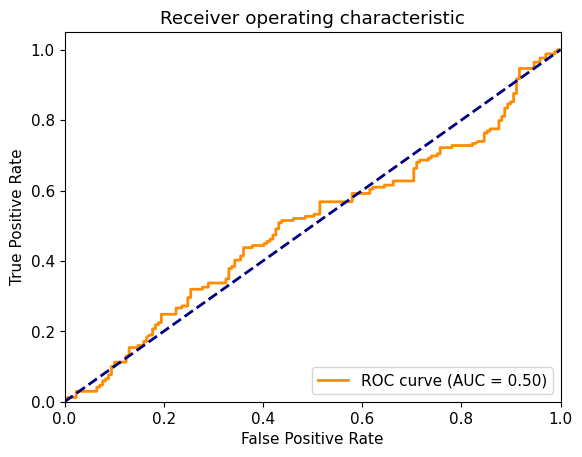

In [66]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline


label = df["label"]
prob = df["prob_MobileNet"]
pred = df["pred_MobileNet"]
prob = df["prob_YOLOv5"]
pred = df["pred_YOLOv5"]

cm = confusion_matrix(label, pred)
accuracy = accuracy_score(label, pred)
sensitivity = recall_score(label, pred)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
ppv = precision_score(label, pred)
f1 = f1_score(label, pred)

print('Confusion Matrix:\n', cm) # 混同行列
print('Accuracy:', accuracy) # 正解率
print('Sensitivity:', sensitivity) # 感度
print('Specificity:', specificity) # 特異度
print('Positive Predictive Value:', ppv) # 陽性的中率
print('F1-Score:', f1) # F1スコア



# 真陽性率（TPR）、偽陽性率（FPR）、しきい値（thresholds）を計算する
fpr, tpr, thresholds = roc_curve(label, prob)

# AUCスコアを計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()




#**Output CoreML**

In [ ]:
###########################
# Output as CoreML_example
###########################
import torch.nn as nn
import torch
import torchvision
!pip install --quiet coremltools
import coremltools as ct
import numpy as np
!pip install --quiet timm


# Load a pre-trained version of MobileNetV3

base_model = timm.create_model('mobilenetv3_large_100', pretrained=True)

class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            base_model,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)

# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()

# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
import urllib
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = class_labels[1:] # remove the first class which is background
assert len(class_labels) == 1000


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)

# Save model
mlmodel.save("MobileNetV3_pytorch.mlmodel")

     |████████████████████████████████| 1.5 MB 6.8 MB/s 


Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1466.69 ops/s]


In [ ]:
###########################
# Output as CoreML 飛ばして下さい
###########################

import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)


# # Convert to Core ML using the Unified Conversion API
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
#     classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
# )

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1744.69 ops/s]


In [ ]:
################################
### Output as CoreML (Tensor type) ###
################################
import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
    classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
)

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")

Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1717.72 ops/s]


#**Interference on CoreML model**

In [ ]:
# This script can be used in Mac only

##https://gist.github.com/ozgurshn/85cf74558d82c831827e12f015f752a1
##https://github.com/apple/coremltools/blob/master/examples/APIExamples.md
import coremltools
import numpy as np
import PIL.Image

# load a model whose input type is "Image"
model = coremltools.models.MLModel('/content/gravcont_mobilenetv3.mlmodel')

Height = 224  # use the correct input image height
Width = 224  # use the correct input image width


# Scenario 1: load an image from disk
def load_image(path, resize_to=None):
    # resize_to: (Width, Height)
    img = PIL.Image.open(path)
    if resize_to is not None:
        img = img.resize(resize_to, PIL.Image.ANTIALIAS)
    img_np = np.array(img).astype(np.float32)
    return img_np, img


# load the image and resize using PIL utilities
_, img = load_image('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_newPatient_250px/スライド1.jpeg', resize_to=(Width, Height))
out_dict = model.predict({'image': img})

# Scenario 2: load an image from a numpy array
shape = (Height, Width, 3)  # height x width x RGB
data = np.zeros(shape, dtype=np.uint8)
# manipulate numpy data
pil_img = PIL.Image.fromarray(data)
out_dict = model.predict({'image': pil_img})

Exception: ignored

##**Interference without Mac**

In [ ]:
#https://tvm.apache.org/docs/how_to/compile_models/from_coreml.html
!pip install --quiet apache-tvm
!pip install --quiet coremltools
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
import coremltools as cm
import numpy as np
from PIL import Image

     |████████████████████████████████| 42.8 MB 1.2 MB/s 


###**Load the model**

In [ ]:
model_url = "https://docs-assets.developer.apple.com/coreml/models/MobileNet.mlmodel"
model_file = "mobilenet.mlmodel"
model_path = download_testdata(model_url, model_file, module="coreml")
# Now you have mobilenet.mlmodel on disk
mlmodel = cm.models.MLModel(model_path)

###**Load the test image**

In [ ]:
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
# Mobilenet.mlmodel's input is BGR format
img_bgr = np.array(img)[:, :, ::-1]
x = np.transpose(img_bgr, (2, 0, 1))[np.newaxis, :]

###**Compile model on relay**

In [ ]:
target = "llvm"
shape_dict = {"image": x.shape}

# Parse CoreML model and convert into Relay computation graph
mod, params = relay.frontend.from_coreml(mlmodel, shape_dict)

with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "


In [ ]:
#Execute on TVM (これはサンプルの通り)
from tvm.contrib import graph_executor

dev = tvm.cpu(0)
dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# set inputs
m.set_input("image", tvm.nd.array(x.astype(dtype)))
# execute
m.run()
# get outputs
tvm_output = m.get_output(0)
top1 = np.argmax(tvm_output.numpy()[0])

###**Look up system name**

In [ ]:
synset_url = "".join(
    [
        "https://gist.githubusercontent.com/zhreshold/",
        "4d0b62f3d01426887599d4f7ede23ee5/raw/",
        "596b27d23537e5a1b5751d2b0481ef172f58b539/",
        "imagenet1000_clsid_to_human.txt",
    ]
)
synset_name = "imagenet1000_clsid_to_human.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synset = eval(f.read())
# You should see the following result: Top-1 id 282 class name tiger cat
print("Top-1 id", top1, "class name", synset[top1])

Top-1 id 282 class name tiger cat
